In [26]:
from commons.load_data import load_data
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch 
# https://arxiv.org/pdf/1312.6114.pdf

There are like a million ways to explain variational autoencoders that are needlessly complicated. Simply look at the loss function to see what is going on:

There is the constuction loss: how far from the input the generated image is 

Then there is the KL divergence loss which is a bit more complicated.
<ol>
    <li> mu and log_var are generated in the encoder, they are then compared to a smaple from a normal distrobution. 
    <li> Basically mu and log_var are penalized if they do not produce a normal distrobution with mean = 0 and std = 1.0
    <li> this "regularizes" the latent space to a normal distrobution

In [27]:
INPUT_DIMS = (28, 28)

class VAE(torch.nn.Module):
    def __init__(self, latent_dims = 16) -> None:
        super(VAE, self).__init__()

        # encoder
        self.flatten = torch.nn.Flatten()
        self.linear1 = torch.nn.Linear(INPUT_DIMS[0] * INPUT_DIMS[1], 256)
        self.linear2 = torch.nn.Linear(256, 128)

        self.linear_mu = torch.nn.Linear(128, latent_dims)
        self.linear_log_var = torch.nn.Linear(128, latent_dims)

        # decoder
        self.linear4 = torch.nn.Linear(latent_dims, 128)
        self.linear5 = torch.nn.Linear(128, 256)
        self.linear6 = torch.nn.Linear(256, INPUT_DIMS[0] * INPUT_DIMS[1])

    def encoder(self, input):
        x = self.flatten(input)

        x = self.linear1(x)
        x = F.selu(x)

        x = self.linear2(x)
        x = F.selu(x)

        mu = self.linear_mu(x)
        log_var = self.linear_log_var(x)

        epsilon = torch.normal(mean = torch.zeros_like(mu), std = torch.ones_like(mu))

        sample = mu + torch.exp(log_var / 2) * epsilon

        return sample, mu, log_var

    def decoder(self, latent_space):
        x = F.selu(latent_space)
        
        x = self.linear4(x)
        x = F.selu(x)

        x = self.linear5(x)
        x = F.selu(x)

        x = self.linear6(x)
        x = torch.sigmoid(x)

        output = torch.reshape(x, (-1, 1, *INPUT_DIMS))
        return output

    def forward(self, input):
        latent_space, mu, log_var = self.encoder(input)
        output = self.decoder(latent_space)
        return output, mu, log_var

In [28]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

train_data, test_data = load_data() # load in data

epochs = 10
batch_size = 32

dkl_weight = .5

train = torch.utils.data.DataLoader(train_data, batch_size = batch_size)
test = torch.utils.data.DataLoader(test_data, batch_size = batch_size)

In [29]:
def loss_fn(output, input, mu, log_var):
    con_loss = F.binary_cross_entropy(output, input)
    dkl_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1))
    return dkl_loss * dkl_weight + con_loss

model = VAE(latent_dims = 16)
opt = torch.optim.SGD(model.parameters(), lr = .005, momentum = 0) # penalizing square of encoded activation could make the network select only one awsners 
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', factor = .2, patience = 1, verbose = True, cooldown = 3)

model.to(device)

VAE(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=128, bias=True)
  (linear_mu): Linear(in_features=128, out_features=16, bias=True)
  (linear_log_var): Linear(in_features=128, out_features=16, bias=True)
  (linear4): Linear(in_features=16, out_features=128, bias=True)
  (linear5): Linear(in_features=128, out_features=256, bias=True)
  (linear6): Linear(in_features=256, out_features=784, bias=True)
)

In [30]:
print(f'Training Started 0/{epochs} epochs')
for epoch in range(epochs):
    train_loss = 0 # init train loss to 0

    for imgs, _ in tqdm(train, mininterval= 0.5):
        imgs = imgs.to(device)
        outputs, mu, log_var = model(imgs)
        loss = loss_fn(outputs, imgs, mu, log_var)
        
        loss.backward()
        opt.step()
        train_loss += loss.item() 

    test_loss = 0 
    with torch.no_grad():
        for imgs, _ in test:
            imgs = imgs.to(device)
            outputs, mu, log_var = model(imgs)
            loss = loss_fn(outputs, imgs, mu, log_var)
            test_loss += loss.item() 
            
    train_loss /= len(train)
    test_loss /= len(test)

    print(f"Epoch: {epoch + 1}/{epochs} complete\tTrain loss: {train_loss:.5f}\t Test loss: {test_loss:.5f}")

    scheduler.step(test_loss)

Training Started 0/10 epochs


 66%|██████▌   | 1235/1875 [00:07<00:03, 164.74it/s]


RuntimeError: all elements of input should be between 0 and 1

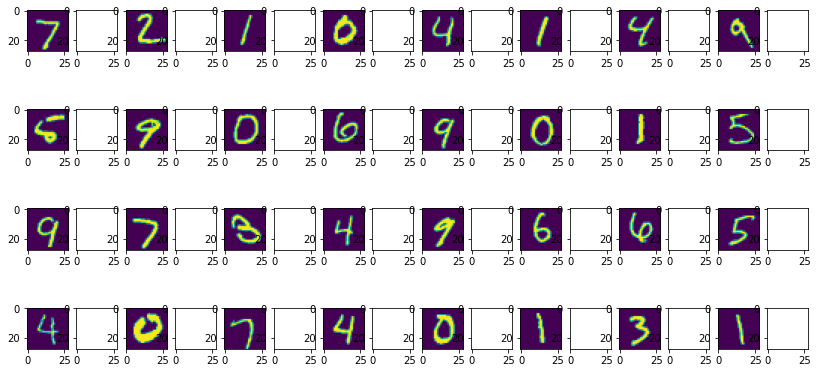

In [31]:
images, _ = iter(test).next()
_, ax = plt.subplots(4, 16, figsize = (14, 7))
with torch.no_grad():
    outputs, _, _ = model(images)

ax_flat = ax.flatten()
for i in range(0, len(ax_flat), 2):
    ax_flat[i+1].imshow(outputs[i//2][0].numpy())
    ax_flat[i].imshow(images[i//2][0].numpy())

In [33]:
import builtins
builtins

<module 'builtins' (built-in)>

In [40]:
x = 1
property(x)